Load Libraries

In [62]:
import os
import time
import faiss
import string
import pickle
import numpy as np
import pandas as pd
import seaborn as sns

from typing import List
from collections import Counter

from sklearn.metrics import accuracy_score

from sklearn.model_selection import train_test_split
from sentence_transformers import SentenceTransformer
from sklearn.metrics import classification_report,confusion_matrix

# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_columns', None)
# pd.set_option('display.max_colwidth', None)

In [63]:
df=pd.read_csv("./data/20_newsgroup.csv")
df=df[["text","title"]]

In [64]:
df.sample(5)

,text,title
3480,"\n\n\nWhat do you mean ""more comfortable putting it up to."" That seems a bit\nhard to evaluate. At least for me it is. \n\nStare straight Point with both hands together and clasp so that only the\npointer fingers are pointing straight forward to a a spot on the wall about\neight feet away. First stare at the spot with both eyes open. Now\nclose your left eye. Now open your left eye. Now close your right eye.\nnow open your right eye.\n\nIf the image jumped more when you closed your right eye, you are right\neye dominant.\n\nIf the image jumped more when you closed your left eye, you are left eye\ndominant.\n",sci.med
555,I just wanted to know:,rec.autos
17,\n\n\n\n\n\nBzzt.\nThe manta was a two-door sedan in the US.\nIt had a 1900 engine.\nWas sometimes referred to as an Opel 1900.\nManta's are also ve hot and fun cars too.\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n,rec.autos
1473,Does anyone know where I can FTP MPEG for DOS from? Thanks for any\nhelp in advance. Email is preferred but posting is fine.\n\n\t\t\t\tScott\n\n\n---------------------------------------------------------------------------,comp.graphics
2401,"\n\n\nThe existence of the weapon in and of itself (and this is also\ntrue for biologics and chemical weapons, but for slightly different\nreasons) poses a threat to living critters. Can you say ""neutron\nand other radiation flux due to radioactive decay"", boys and girls?",talk.politics.guns


In [65]:
df["title"].value_counts()

title
rec.sport.hockey            600
soc.religion.christian      599
rec.motorcycles             598
rec.sport.baseball          597
sci.crypt                   595
rec.autos                   594
sci.med                     594
comp.windows.x              593
sci.space                   593
comp.os.ms-windows.misc     591
sci.electronics             591
comp.sys.ibm.pc.hardware    590
misc.forsale                585
comp.graphics               584
comp.sys.mac.hardware       578
talk.politics.mideast       564
talk.politics.guns          546
alt.atheism                 480
talk.politics.misc          465
talk.religion.misc          377
Name: count, dtype: int64

In [66]:
df['title'].unique()

array(['rec.autos', 'comp.sys.mac.hardware', 'comp.graphics', 'sci.space',
       'talk.politics.guns', 'sci.med', 'comp.sys.ibm.pc.hardware',
       'comp.os.ms-windows.misc', 'rec.motorcycles', 'talk.religion.misc',
       'misc.forsale', 'alt.atheism', 'sci.electronics', 'comp.windows.x',
       'rec.sport.hockey', 'rec.sport.baseball', 'soc.religion.christian',
       'talk.politics.mideast', 'talk.politics.misc', 'sci.crypt'],
      dtype=object)

In [67]:
df["text"].iloc[1500]

'Hi, can anyone direct me to map type gifs? \n\nI am interesting in cartography and would find\nthese gifs useful.\n\ntia,\n'

In [68]:
len(df)

11314

## selecting few diverse classes for usecase

In [69]:
list_=['sci.space','comp.sys.mac.hardware','soc.religion.christian','sci.med','rec.sport.hockey','sci.crypt','comp.graphics']
selected=df[df["title"].isin(list_)]

In [70]:
selected.drop_duplicates(inplace=True)

/var/folders/0w/7szmzlg15ljc6n0sn48w0jph0000gq/T/ipykernel_20284/1199455941.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected.drop_duplicates(inplace=True)


In [71]:
# selected_df=selected.groupby('title').sample(400)

selected["text"]=selected["text"].astype(str)

/var/folders/0w/7szmzlg15ljc6n0sn48w0jph0000gq/T/ipykernel_20284/1964287960.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected["text"]=selected["text"].astype(str)


In [72]:
len(selected)

4064

In [73]:
selected[["text","title"]].sample(5)

text  \
8066                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          A fine 26 year history came to a close tonight, as the Minnesota North Stars, \nor Norm's Stars (whichever you prefer) lost to the Red Wings by a score of\n5-3.  The Stars goals were scored by Mike McPhee and Ulf Dahlen, who netted\ntwo including the final one in franchise history, with less than a minute to\nplay.\n\nTonight, on the air on the Stars TV telecast, announcer Al Shaver, the voi

## Data Cleaning

In [74]:
import re

def clean(text):
    text=text.lower()
    url_removed=re.sub(r'https\S+','',text,flags=re.MULTILINE)
    text=re.sub("[^a-zA-Z]"," ",url_removed)
    text=re.sub("\.+"," ",text)
    text=[word for word in text if word not in string.punctuation]
    text="".join(text).strip()
    text=re.sub("\s\s+", " ", text)
    return "".join(text).strip()


selected["cleaned_data"]=selected["text"].apply(lambda x:clean(x) if x!=None else x)

/var/folders/0w/7szmzlg15ljc6n0sn48w0jph0000gq/T/ipykernel_20284/473358746.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected["cleaned_data"]=selected["text"].apply(lambda x:clean(x) if x!=None else x)


## Split into train and test

In [75]:
train,test= train_test_split(selected,stratify=selected[["title"]],test_size=0.2)
train.reset_index(drop=True,inplace=True)
test.reset_index(drop=True,inplace=True)

In [76]:
train['title'].value_counts()

title
soc.religion.christian    476
rec.sport.hockey          470
sci.crypt                 467
sci.med                   466
sci.space                 463
comp.graphics             459
comp.sys.mac.hardware     450
Name: count, dtype: int64

## Save the data

In [77]:
train.to_csv("train_data.csv",index=False)
test.to_csv("test_data.csv",index=False)

## Generate Embedding using paralleism

In [78]:
model=SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
train_cleaned_texts = train["cleaned_data"].tolist()
train_cleaned_texts = list(map(str, train_cleaned_texts))
import time
import os

def get_embeddings(model, sentences: List[str], parallel: bool = True):
    start = time.time()
    if parallel:
        # Start the multi-process pool on all cores
        os.environ["TOKENIZERS_PARALLELISM"] = "false"
        pool = model.start_multi_process_pool(target_devices=["cpu"] * 5)
        embeddings = model.encode_multi_process(sentences, pool, batch_size=16)
        model.stop_multi_process_pool(pool)
    else:
        os.environ["TOKENIZERS_PARALLELISM"] = "true"
        embeddings = model.encode(
            sentences,
            batch_size=32,
            show_progress_bar=True,
            convert_to_tensor=True,
        )
    print(f"Time taken to encode {len(sentences)} items: {round(time.time() - start, 2)}")
    return embeddings.detach().numpy()

train_embeddings = get_embeddings(model=model, sentences=train_cleaned_texts, parallel=False)
print(train_embeddings.shape)

#save embeddings of idea texts
cleaned_train_texts_embeddings_file = f"./data/train_embeddings_all_minilm_l6_v2.pkl"
pickle.dump(train_embeddings, open(cleaned_train_texts_embeddings_file, "wb"))




Batches:   0%|          | 0/102 [00:00<?, ?it/s]

Time taken to encode 3251 items: 154.63
(3251, 384)


## create mappings

In [79]:
#create mappings for index and category this will be later used for faiss
train_category_index_mapping=dict(zip(train.index,train.title))
with open('./data/train_category_index.pickle', 'wb') as handle:
    pickle.dump(train_category_index_mapping, handle, protocol=pickle.HIGHEST_PROTOCOL)

#load the mappings file which is used for printing category as output
def get_mappings(file_name):
    with open(file_name, 'rb') as handle:
        category_mapping_dict = pickle.load(handle)
    return category_mapping_dict


mappings = get_mappings(file_name='./data/train_category_index.pickle')

# load embeddings 

In [80]:


#read the embeddings created at earlier step
def read_embeddings(file_name):
    cleaned_texts_embeddings_file = file_name
    if os.path.exists(cleaned_texts_embeddings_file):
        with open(cleaned_texts_embeddings_file, "rb") as f:
            embeddings = pickle.load(f)
    temp1=np.asarray(embeddings,dtype="float32")
    return temp1


    return

samples = read_embeddings(file_name=f"./data/train_embeddings_all_minilm_l6_v2.pkl")

## Creating and saving index

In [81]:


#save the index once its created
def save_index(index):
    path = os.path.join("./data/","news_train_index")
    faiss.write_index(index, path)

# we have used flat Index and with Inner product
def create_index(mappings,samples):
    index = faiss.IndexIDMap(faiss.IndexFlatIP(samples.shape[1]))
    faiss.normalize_L2(samples)  # normalise the embedding
    #index.train(samples)
    index.add_with_ids(samples,np.array(list(mappings.keys())))
    save_index(index)
create_index(mappings=mappings,samples=samples)

In [82]:
# print top 2 categories among top5 nearest neighbours returned from index search
train=pd.read_csv("train_data.csv") # using the file from previous notebook created step
test=pd.read_csv("test_data.csv")




## read the index and search for test query in index using predict function

In [83]:



#read the index
index = faiss.read_index("./data/news_train_index")

# embeddings for query
def predict_embeddings(query):
    query_embedding=model.encode(query)
    query_embedding=np.asarray([query_embedding],dtype="float32")
    return query_embedding
    

#predict for given query
def predict(query,mappings):
    cleaned_query= clean(query)
    query_embedding=predict_embeddings(cleaned_query)
    faiss.normalize_L2(query_embedding)
    D, I = index.search(query_embedding, 10) # d is the distance and I is the index number 
    D=[np.unique(D)]
    I=[np.unique(I)]
    res_df=[]
    for values in I:
        for val in D:
            details= {'cleaned_text':list(train.iloc[values]["cleaned_data"]),
            'category':list(train.iloc[values]["title"]),
            'score':list(val)
            }
            res_df.append(details)
    return res_df


## obtain most frequent class or final class

In [84]:

def most_frequent(result):
    top2 = Counter(result)
    return top2.most_common(1)

In [85]:
pd.set_option('display.max_rows', None)


In [86]:
 res=predict("glycemic index",mappings=mappings)

In [87]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.DataFrame(res[0])

,cleaned_text,category,score
0,blood glucose levels of or so are common several hours after a big meal this level will usually not cause symptoms if you mean reactive hypoglycemia there are usually no symptoms hence there is no disease hence the dietary recommendations are the same as for anyone else if a patient complains of dizziness faintness sweating palpitations etc reliably several hours after a big meal the recommendations are obvious eat smaller meals,sci.med,0.335596
1,check out the diabetic mailing list a knowledgable helpful friendly voluminous bunch send email to listserv pccvm bitnet with this line in the body subscribe diabetic your name here also the vote for misc health diabetes a newsgroup for general discussion of diabetes is currently underway and will close on april from the nd cfv posted to news announce newgroups news groups and sci med message q jshinn v rodan uu net,sci.med,0.338126
2,serum actually but plasma numbers are the same whole blood numbers for humans tend to be somewhat lower roughly to percent lower i find the following range for whole blood in fundamentals of clinical chemistry n w teitz editor w b saunders human glucose whole blood fasting levels mg dl indeed they do measure whole blood levels although they are not as accurate as a serum test done in a laboratory one problem is that cells in the sample continue to metabolize glucose after the sample is drawn reducing the apparent level according to teitz however results compare reasonably well with laboratory results although values below mg dl tend to be lower with strip tests whereas values above mg dl can be very erratic as stated above whole blood levels tend to be roughly to percent lower than serum levels sample freshness will affect whole blood levels however i don t believe there is a well defined conversion factor since cell metabolism will affect samples to varying degrees the serum plasma test is much preferred for any except general ball park testing,sci.med,0.349964
3,my blood pressure soars my heart pounds and i can t get to sleep for the life of me feels about like i just drank cups of coffee i avoid it and beet sugar flavor enhancers beet powder and whatever other names it may go under basicaly i read the ingredients and if i don t know what they all are i don t buy the product msg sensitivity is definately real relativity schmelativity richard h clark my opinions are my own and lunatik watch for me on the road ought to be yours but under it s not my fault i voted perot no circumstances are they richard tis com those of my company,sci.med,0.353059
4,a can anyone tell me if a bloodcount of when diagnosed as hypoglycemic is a dangerous i e indicates a possible pancreatic problem one dr says no the a other not his specialty says the first is negligent and that another blood a test should be done also what is a good diet what has worked for a hypo a glycemic tia a a a anthony anello a fermilab a batavia illinois once you have your hypoglycemia confirmed through the proper channels you might consider ther following chelated manganese mg day chelated chromium mcg day increase protein through foods or supplements avoid supplements foods high in potassium calcium zinc avoid vit c supplements in excess of mg avoid honey and foods high in simple sugars enjoy breads cereals grains discuss the above with your health practitioner for compatibility with your body chemistry and safety ron,sci.med,0.366020
5,jb jb ron roth recommends once you have your hypoglycemia confirmed through the jb proper channels you might consider the following jb diet omitted jb jb ron what do you consider to be proper channels this sounds suspiciously i m glad it caught your eye that s the purpose of this forum to educate those eager to learn about the facts of life that phrase is used to bridle the frenzy of all the would be respondents who otherwise would feel being left out as the proper authorities to be consulted on that topic in short it means absolutely 

## Test Data Prediction

In [88]:



def test_predict(query,mappings=mappings):
    cleaned_query= clean(query)
    query_embedding=predict_embeddings(cleaned_query)
    faiss.normalize_L2(query_embedding)
    D, I = index.search(query_embedding, 5) # d is the distance and I is the index number 
    return most_frequent([mappings[id_] for id_ in I[0]])[0][0]


test["predict"]=test["cleaned_data"].astype(str).apply(lambda x:test_predict(x))

# time taken for flat index

In [89]:
start=time.time()
print(test_predict("intel graphics card",mappings),time.time()-start)

comp.graphics 0.017541885375976562


# Evaluate flat index results

In [90]:
print(classification_report(test['title'],test["predict"]))
cm = confusion_matrix(test['title'],test["predict"])

                        precision    recall  f1-score   support

         comp.graphics       0.87      0.82      0.85       114
 comp.sys.mac.hardware       0.93      0.89      0.91       112
      rec.sport.hockey       0.97      0.95      0.96       118
             sci.crypt       0.93      0.92      0.93       117
               sci.med       0.95      0.91      0.93       117
             sci.space       0.88      0.91      0.89       116
soc.religion.christian       0.86      0.97      0.91       119

              accuracy                           0.91       813
             macro avg       0.91      0.91      0.91       813
          weighted avg       0.91      0.91      0.91       813



<Axes: >

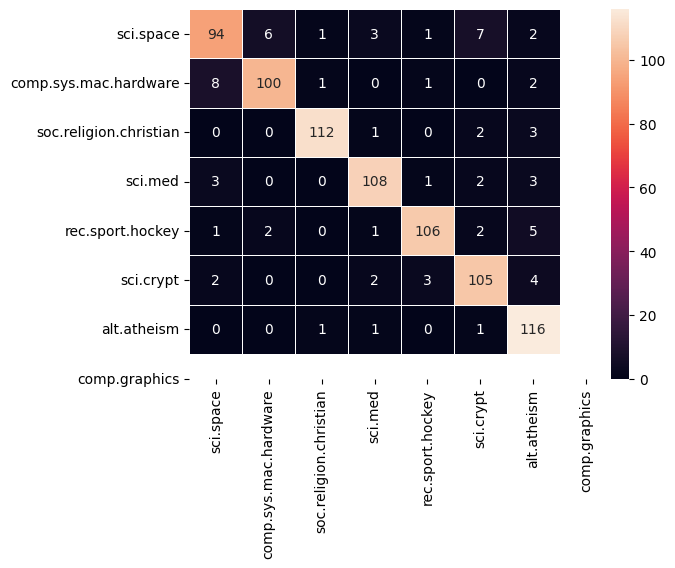

In [91]:

labels = ['sci.space','comp.sys.mac.hardware','soc.religion.christian','sci.med','rec.sport.hockey','sci.crypt','alt.atheism','comp.graphics']
sns.heatmap(cm, fmt='d', annot=True,
     # set all to white
            linewidths=0.5, linecolor='w',  # draw black grid lines
            xticklabels=labels,yticklabels=labels)                     # disable colorbar

# # re-enable outer spines
# sns.despine(left=False, right=False, top=False, bottom=False)

In [92]:
acc_score = accuracy_score(test['title'],test["predict"])
print("Test Accuracy Score",acc_score)

Test Accuracy Score 0.9114391143911439


In [93]:
from sklearn.metrics import f1_score
print("f1 score",f1_score(test['title'],test["predict"],average="macro"))

f1 score 0.9110166876133035


# Experimenting with ivfflat index

In [94]:
# second index 


#save the index once its created
def save_index(index):
    path = os.path.join("./data/","news_ivf_flat")
    faiss.write_index(index, path)


nlist = 5  # number of clusters
dimension=384 # embeddings dimension

# we have used flat Index and with Inner product
def create_index_ivf(mappings,samples,nlist=nlist,dimension=dimension):
    quantiser = faiss.IndexFlatL2(dimension)  
    index = faiss.IndexIVFFlat(quantiser, dimension, nlist,   faiss.METRIC_L2)
    index.train(samples)
    index.add(samples)   # add the vectors and update the index
    print(index.is_trained)  # True
    print(index.ntotal)  
    index.add_with_ids(samples,np.array(list(mappings.keys())))
    save_index(index)
    return


create_index_ivf(mappings=mappings,samples=samples)

True
3251


# Reading and searching inside ivfflat index

In [95]:



#read the index
index = faiss.read_index("./data/news_ivf_flat")

# embeddings for query
def predict_embeddings(query):
    query_embedding=model.encode(query)
    query_embedding=np.asarray([query_embedding],dtype="float32")
    return query_embedding
    

#predict for given query
def predict(query,mappings):
    cleaned_query= clean(query)
    query_embedding=predict_embeddings(cleaned_query)
    faiss.normalize_L2(query_embedding)
    D, I = index.search(query_embedding, 10) # d is the distance and I is the index number 
    D=[np.unique(D)]
    I=[np.unique(I)]

    for values in I:
        for distance in D:
            details= {'cleaned_text':train.iloc[values]["cleaned_data"],
            'category':train.iloc[values]["title"],
            'score':distance
            }
            print("===============================================")
            print(pd.DataFrame(details))
            print("===============================================")
    return most_frequent([mappings[id_] for id_ in I[0]])

In [96]:
res=predict(query="'I was wondering if anyone out there could enlighten me on this car I saw\nthe other day. It was a 2-door sports car, looked to be from the late 60s/\nearly 70s. It was called a Bricklin. The doors were really small. In addition,\nthe front bumper was separate from the rest of the body. This is \nall I know. If anyone can tellme a model name, engine specs, years\nof production, where this car is made, history, or whatever info you\nhave on this funky looking car, please e-mail.",mappings=mappings)

In [97]:
def test_predict_ivf(query,mappings=mappings):
    cleaned_query= clean(query)
    query_embedding=predict_embeddings(cleaned_query)
    faiss.normalize_L2(query_embedding)
    D, I = index.search(query_embedding, 5) # d is the distance and I is the index number 
    return most_frequent([mappings[id_] for id_ in I[0]])[0][0]


test["predict_ivf"]=test["cleaned_data"].astype(str).apply(lambda x:test_predict_ivf(x))

## time taken for ivfflat

In [98]:
start=time.time()
print(test_predict_ivf("intel graphics",mappings),time.time()-start)

comp.sys.mac.hardware 0.01819300651550293


## evaluate ivfflat results

                        precision    recall  f1-score   support

         comp.graphics       0.81      0.84      0.82       114
 comp.sys.mac.hardware       0.90      0.84      0.87       112
      rec.sport.hockey       0.90      0.93      0.92       118
             sci.crypt       0.93      0.92      0.93       117
               sci.med       0.92      0.84      0.88       117
             sci.space       0.88      0.88      0.88       116
soc.religion.christian       0.91      0.98      0.94       119

              accuracy                           0.89       813
             macro avg       0.89      0.89      0.89       813
          weighted avg       0.89      0.89      0.89       813



<Axes: >

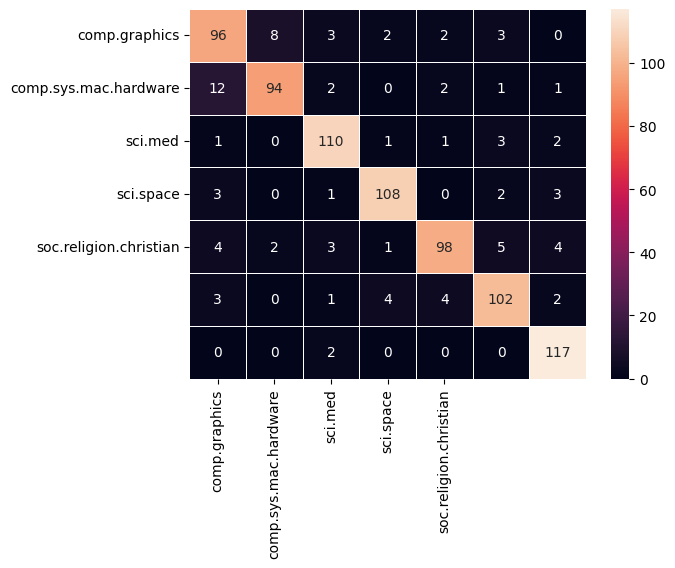

In [99]:

print(classification_report(test['title'],test["predict_ivf"]))
cm2 = confusion_matrix(test['title'],test["predict_ivf"])
labels = ['comp.graphics','comp.sys.mac.hardware','sci.med','sci.space','soc.religion.christian']
sns.heatmap(cm2, fmt='d', annot=True,
     # set all to white
            linewidths=0.5, linecolor='w',  # draw black grid lines
            xticklabels=labels,yticklabels=labels)   

In [100]:
print(classification_report(test['title'],test["predict_ivf"]))
cm2 = confusion_matrix(test['title'],test["predict_ivf"])

                        precision    recall  f1-score   support

         comp.graphics       0.81      0.84      0.82       114
 comp.sys.mac.hardware       0.90      0.84      0.87       112
      rec.sport.hockey       0.90      0.93      0.92       118
             sci.crypt       0.93      0.92      0.93       117
               sci.med       0.92      0.84      0.88       117
             sci.space       0.88      0.88      0.88       116
soc.religion.christian       0.91      0.98      0.94       119

              accuracy                           0.89       813
             macro avg       0.89      0.89      0.89       813
          weighted avg       0.89      0.89      0.89       813



In [101]:
acc_score = accuracy_score(test['title'],test["predict_ivf"])
print("Test Accuracy Score",acc_score)

Test Accuracy Score 0.8917589175891759


In [102]:
fl_score = f1_score(test['title'],test["predict_ivf"],average="macro")
print("Test fl Score",fl_score)

Test fl Score 0.8908526757621126
